## Initialization

### Imports

In [29]:
import lgbm_optuna_aqi_wrapper as lgbm_wr
from statsmodels.tsa.api import SimpleExpSmoothing
import params_searchers.ts_splitter as ts_splitter
from sklearn import metrics
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### Constants

In [30]:
TRAIN_DATE_FROM = '2015-01-08'
TRAIN_DATE_TO = '2023-02-05'
VAL_DATE_FROM = '2023-02-06'
VAL_DATE_TO = '2023-02-12'

CSV_JOINT_FILE = '../../datasources/ds_joint/ds.csv'

### Data load

In [31]:
df_joint = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')

In [32]:
x_val, y_val = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=VAL_DATE_FROM, dt_end=VAL_DATE_TO)
x_train, y_train = ts_splitter.split_x_y_for_period(df=df_joint, index_cols='DatetimeEnd', y_value_col='AQI',                                                           dt_start=TRAIN_DATE_FROM, dt_end=TRAIN_DATE_TO)

df_res = pd.DataFrame(index=y_val.index)
df_res['AQI_VAL'] = y_val
display(df_res)

,AQI_VAL
DatetimeEnd,
2023-02-06,115
2023-02-07,139
2023-02-08,143
2023-02-09,127
2023-02-10,97
2023-02-11,74
2023-02-12,128


### Functions

In [33]:
def get_prediction(df, pol_id, use_aqi_cols, use_c_mean_cols, best_par, best_cat, best_feat_count):
    o_helper, x_tr, y_tr, x_vl, y_vl = lgbm_wr.init_optuna(
        df=df, pol_id=pol_id, prediction_value_type=lgbm_wr.PredictionValueType.AQI,
        use_aqi_cols=use_aqi_cols, use_c_mean_cols=use_c_mean_cols, use_lag_cols=True, use_gen_lags_cols=True, use_weather_cols=True,
        train_start_dt=TRAIN_DATE_FROM, train_end_dt=TRAIN_DATE_TO, test_start_dt=VAL_DATE_FROM, test_end_dt=VAL_DATE_TO,
        default_params=best_par, default_category=best_cat)

    o_helper.set_best_features_by_count(best_feat_count)
    o_helper.study_best_params = best_par
    score_tr, score_vl, mdl = o_helper.run_model_and_eval(params=best_par,  categorical_features=best_cat, best_features_only=True, set_as_best_model=True)
    y_vl_pred = [int(round(x, 0)) for x in o_helper.predict_by_best_model(x_vl)]
    print(f'train score: {score_tr}, val score: {score_vl}')
    return y_vl_pred

## LGBM (+ weather, + lags, + gen lags) forecast

### O3

In [34]:
best_o3_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2600, 'num_leaves': 29, 'learning_rate': 0.12226624793990773, 'subsample': 0.8259925800585568, 'subsample_freq': 6, 'subsample_for_bin': 311124, 'min_child_samples': 13, 'reg_alpha': 0.1877661803380422, 'reg_lambda': 0.12122085900675779, 'max_depth': 7, 'max_bin': 346}
best_o3_categories =  ['season', 'month', 'year']
best_o3_features_count = 19

y_val_o3 = get_prediction(df=df_joint, pol_id=7, use_aqi_cols=True, use_c_mean_cols=False, best_par=best_o3_params,
                          best_cat=best_o3_categories, best_feat_count=best_o3_features_count)

df_res['AQI_O3_l_gl_w'] =  y_val_o3

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
train score: 3.1890261080175812, val score: 8.580380904072792


### PM 2.5

In [35]:
best_pm25_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 2100, 'num_leaves': 97, 'learning_rate': 0.11890042003021366, 'subsample': 0.4318782580934736, 'subsample_freq': 0, 'subsample_for_bin': 193295, 'min_child_samples': 14, 'reg_alpha': 0.394194026403052, 'reg_lambda': 0.708405421324422, 'max_depth': 3, 'max_bin': 206}
best_pm25_categories =  ['month', 'weekday']
best_pm25_features_count = 133

y_val_pm25 = get_prediction(df=df_joint, pol_id=6001, use_aqi_cols=False, use_c_mean_cols=True, best_par=best_pm25_params,
                          best_cat=best_pm25_categories, best_feat_count=best_pm25_features_count)

df_res['AQI_PM25_l_gl_w'] =  y_val_pm25

train score: 6.3802608635332065, val score: 38.65786545468789


### PM 10

In [36]:
best_pm10_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': False, 'n_estimators': 1100, 'num_leaves': 55, 'learning_rate': 0.13336706254004013, 'subsample': 0.7110931352351093, 'subsample_freq': 0, 'subsample_for_bin': 194563, 'min_child_samples': 45, 'reg_alpha': 0.18017308854453762, 'reg_lambda': 0.8264670184761244, 'max_depth': 5, 'max_bin': 270}

best_pm10_categories =  ['season', 'weekday']
best_pm10_features_count = 31

y_val_pm10 = get_prediction(df=df_joint, pol_id=5, use_aqi_cols=False, use_c_mean_cols=True, best_par=best_pm10_params,
                          best_cat=best_pm10_categories, best_feat_count=best_pm10_features_count)

df_res['AQI_PM10_l_gl_w'] =  y_val_pm10

train score: 3.337251537037417, val score: 6.989747084609031


### NO2

In [37]:
best_no2_params = {'n_jobs': -1, 'verbosity': -1, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'extra_trees': True, 'n_estimators': 2200, 'num_leaves': 140, 'learning_rate': 0.076297211673832, 'subsample': 0.9048416321209771, 'subsample_freq': 1, 'subsample_for_bin': 141792, 'min_child_samples': 48, 'reg_alpha': 0.31049100804293384, 'reg_lambda': 0.7272704696443957, 'max_depth': 4, 'max_bin': 307}

best_no2_categories =  ['season', 'month']
best_no2_features_count = 30
y_val_no2 = get_prediction(df=df_joint, pol_id=8, use_aqi_cols=True, use_c_mean_cols=False, best_par=best_no2_params,
                          best_cat=best_no2_categories, best_feat_count=best_no2_features_count)
df_res['AQI_NO2_l_gl_w'] =  y_val_no2

train score: 4.45541823885513, val score: 3.102035721368486


### Gen AQI from best LGBM forecast

In [38]:
df_res['AQI_GEN_l_gl_w'] = df_res[['AQI_O3_l_gl_w', 'AQI_PM25_l_gl_w', 'AQI_PM10_l_gl_w', 'AQI_NO2_l_gl_w']].values.max(axis=1)
display(df_res)
score_lgbm_weather = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_GEN_l_gl_w'].values))
score_lgbm_weather

,AQI_VAL,AQI_O3_l_gl_w,AQI_PM25_l_gl_w,AQI_PM10_l_gl_w,AQI_NO2_l_gl_w,AQI_GEN_l_gl_w
DatetimeEnd,,,,,,
2023-02-06,115,19,92,22,30,92
2023-02-07,139,15,106,27,33,106
2023-02-08,143,19,106,27,33,106
2023-02-09,127,19,77,23,36,77
2023-02-10,97,19,70,20,36,70
2023-02-11,74,25,51,20,31,51
2023-02-12,128,18,76,20,33,76


36.740402050836934

## Simple Mean forecast

In [39]:
df_res['AQI_mean'] = y_train.mean()
score_mean = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_mean'].values))
score_mean

73.39232619364556

## Simple Exponential Smoothing forecasts

In [40]:
ses = SimpleExpSmoothing(y_train)
model_ses_a01 = ses.fit(smoothing_level = 0.1, optimized = False)
df_res['AQI_ses_a01']= model_ses_a01.forecast(7)
score_ses_a01 = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_ses_a01'].values))
score_ses_a01

67.64332892006772

In [41]:
ses = SimpleExpSmoothing(y_train)
model_ses_a05 = ses.fit(smoothing_level = 0.5, optimized = False)
df_res['AQI_ses_a05']= model_ses_a05.forecast(7)
score_ses_a05 = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_ses_a05'].values))
score_ses_a05

48.78147652509805

In [42]:
ses = SimpleExpSmoothing(y_train)
model_ses_a1 = ses.fit(smoothing_level = 1, optimized = False)
df_res['AQI_ses_a1']= model_ses_a1.forecast(7)
score_ses_a1 = math.sqrt(metrics.mean_squared_error(df_res['AQI_VAL'].values, df_res['AQI_ses_a1'].values))
score_ses_a1

43.936642696371

## Plots

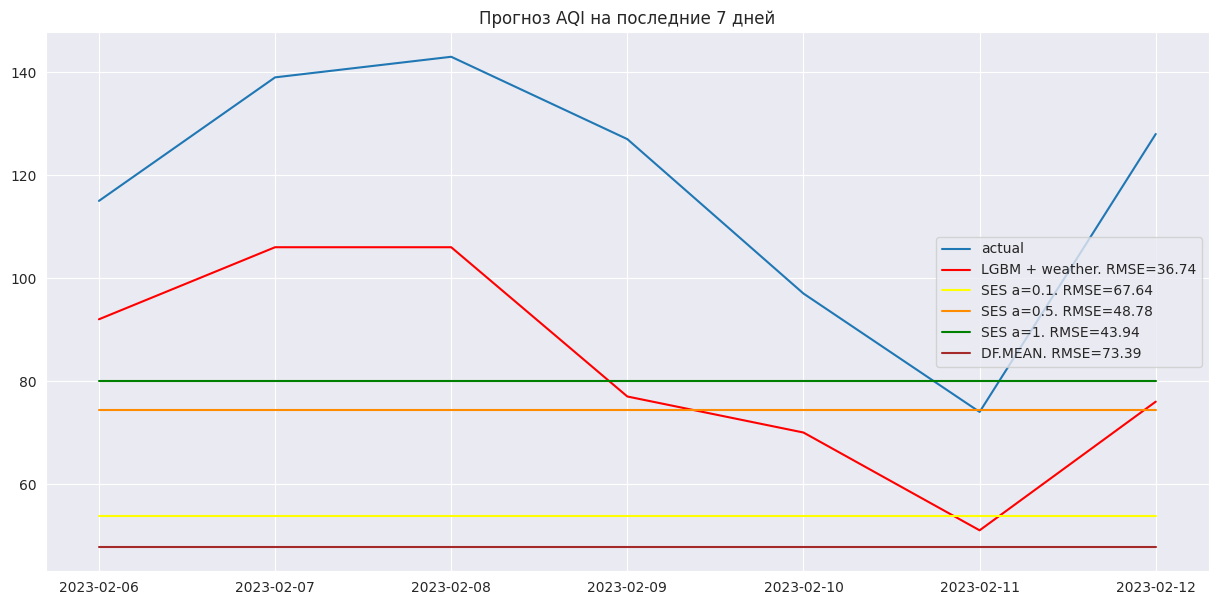

In [43]:
plt.figure(figsize=(15, 7))
plt.title(f"Прогноз AQI на последние 7 дней")
plt.plot(df_res['AQI_VAL'], label="actual")
plt.plot(df_res['AQI_GEN_l_gl_w'], color="r", label="LGBM + weather. RMSE=%.2f" % score_lgbm_weather)
#plt.plot(predictions, color="r", label="ARIMA(0,1,6). RMSE=%.2f" % rmse_arima_fin)
plt.plot(df_res['AQI_ses_a01'], color="yellow", label="SES a=0.1. RMSE=%.2f" % score_ses_a01)
plt.plot(df_res['AQI_ses_a05'], color="darkorange", label="SES a=0.5. RMSE=%.2f" % score_ses_a05)
plt.plot(df_res['AQI_ses_a1'], color="g", label="SES a=1. RMSE=%.2f" % score_ses_a1)
plt.plot(df_res['AQI_mean'], color="brown", label="DF.MEAN. RMSE=%.2f" % score_mean)
plt.plot()
plt.legend()
plt.grid(True)
plt.show()